## Notebook set up

Submit your notebook to the class leaderboard on HuggingFace at [huggingface.co/spaces/gperdrizet/leaderboard](https://huggingface.co/spaces/gperdrizet/leaderboard)

**Your task**: Apply at least two different feature engineering techniques to the `housing_df` dataframe to improve the dataset. At the end of the notebook, your engineered dataset and the original dataset will be used to train a linear regression model to predict `MedHouseVal`. Your goal is to achieve better model performance via feature engineering.

Don't change any of the code in the Model evaluation section of the notebook, especially the output saving. Otherwise the leaderboard scoring may not work!

**Note**: If you have read ahead or you are familiar with the basics of training ML models, no there is no train-test split and yes, this means data leakage/genralizability is a concern. We will cover those topics in the next unit. For now, the goal is to keep things simple while still giving you an idea of how your feature engineering effects model performance.

Before applying transformations, explore the dataset to understand what techniques would be most beneficial.

### Import libraries

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler

# Set random seed for reproducibility
np.random.seed(315)

### Load dataset

In [2]:
# Load California housing dataset
original_housing_df = pd.read_csv('https://gperdrizet.github.io/FSA_devops/assets/data/unit2/california_housing.csv')
housing_df = original_housing_df.copy()

## Task 1: Explore the dataset

Before deciding what feature engineering techniques to apply, explore the dataset to understand its characteristics.

**Things to investigate**:
- Display basic information about the dataset (`.info()`, `.describe()`)
- Check for missing values
- Examine feature distributions (histograms, box plots)
- Look at feature scales and ranges

Use this exploration to inform your feature engineering decisions in the following tasks.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB
             MedInc      HouseAge      AveRooms     AveBedrms    Population  \
count  20640.000000  20640.000000  20640.000000  20640.000000  20640.000000   
mean       3.870671     28.639486      5.429000      1.096675   1425.476744   
std        1.899822     12.585558      2.474173      0.473911   1132.462122   
min        0.499900      1.000000      0.846154      0.333333      3.00000

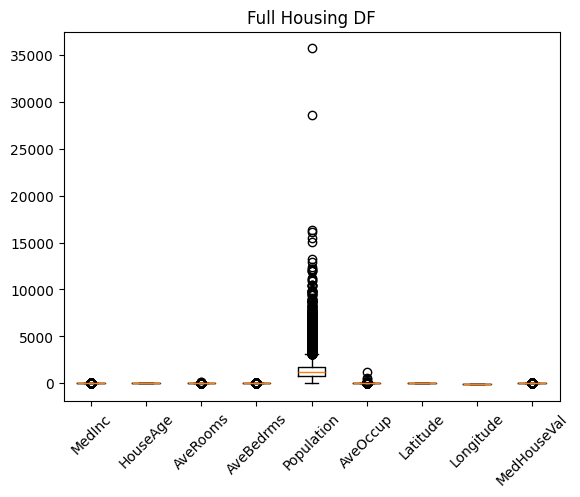

In [22]:
housing_df.info()
print(housing_df.describe())

#original unitless boxplot just to see, lets transform this to get a more clear view of the data relationships
plt.boxplot(housing_df)
plt.title('Full Housing DF')
plt.xticks(
    ticks=range(1, len(housing_df.columns) + 1),
    labels=housing_df.columns,
    rotation=45
)

plt.show()


1. Initial thoughts on the info, shows us there doesn't seem to be any nulls at first. Potential null string substitutes could exist i.e. N/A
2. Describe shows us there are definitely outliers on some of the features, the mean and maxes on them are far off considering the std.
3. Population values are skewing how we can visualize the rest of the data, so we should transform our data to get a better view of the relationship of our data

## Task 2: Apply your first feature engineering technique

Based on your exploration, apply your first feature engineering technique.

**Example approaches**:
- Transform skewed features using log, sqrt, power, or quantile transformations
- Create bins/categories from continuous variables
- Create interaction features (e.g., rooms per household = total rooms / households)

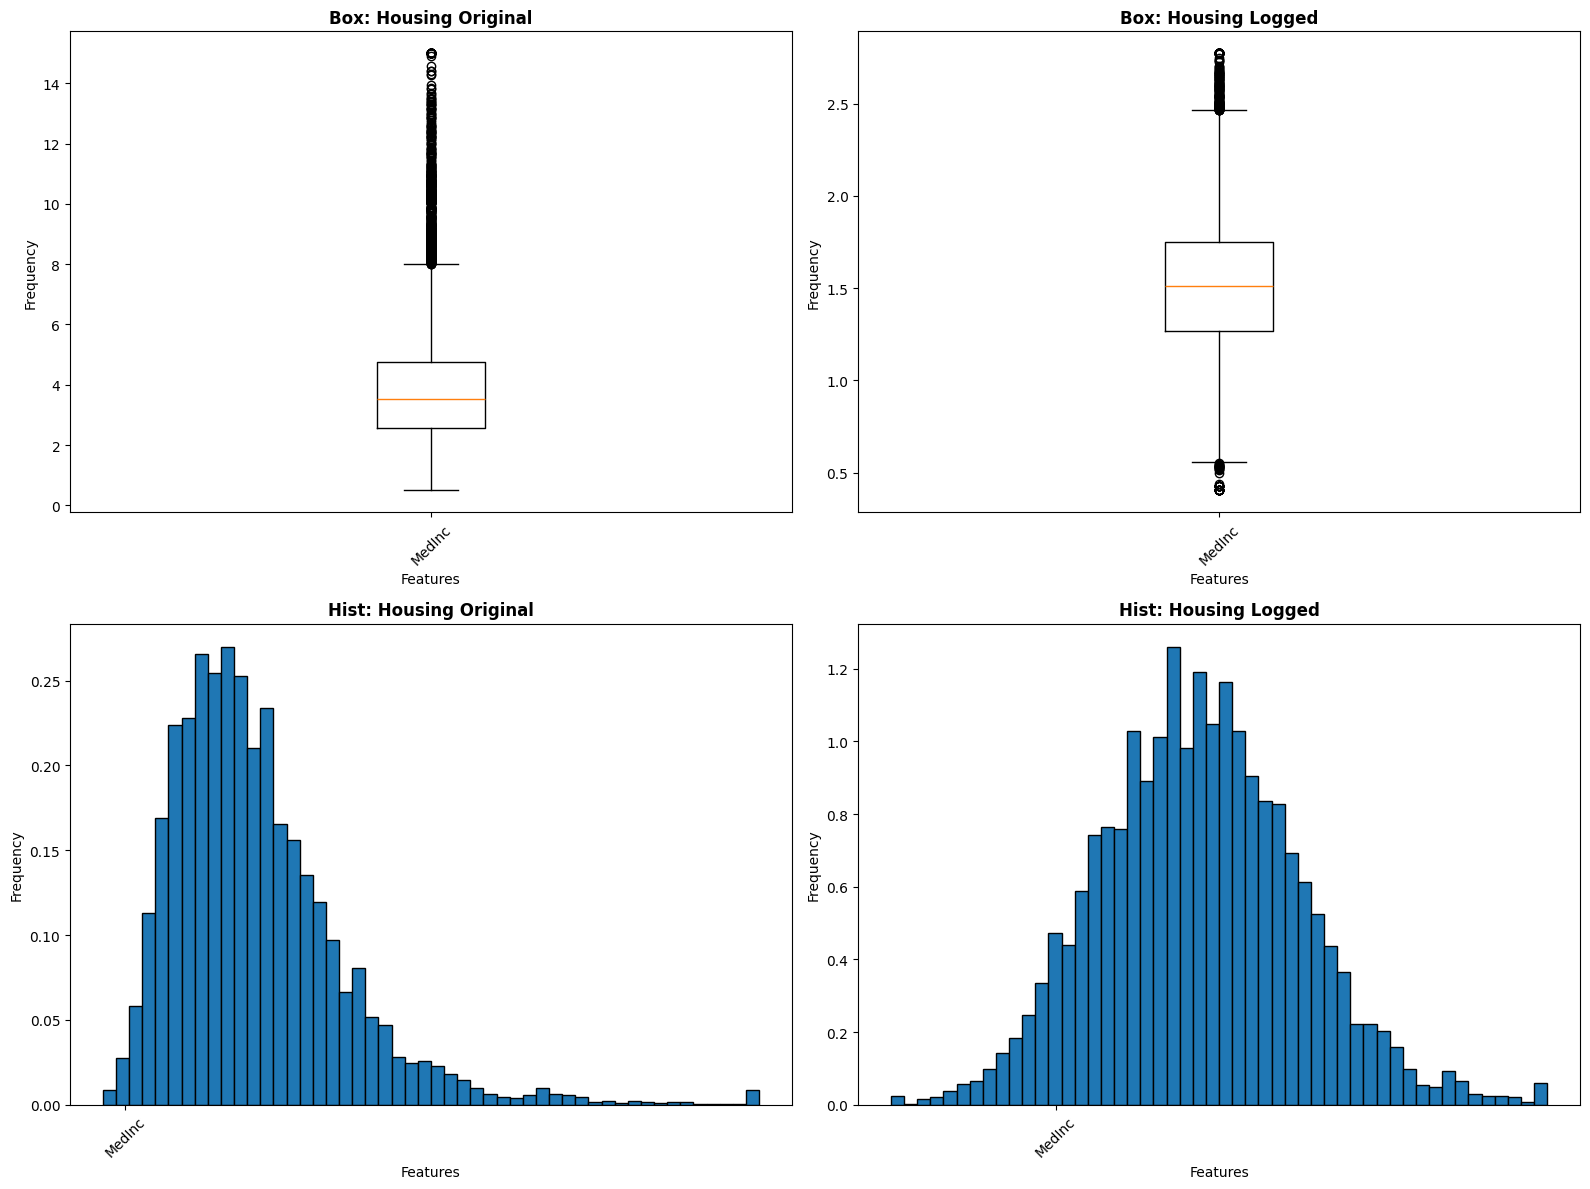

In [53]:
#Logged transformation of housing_df
feature = ['MedInc']

before_housing_logged = housing_df[feature]

#Transform
housing_logged = np.log1p(housing_df[feature])

fig, axes = plt.subplots(2, 2, figsize=(16,12))

axes[0, 0].set_title('Box: Housing Original', fontweight='bold')
axes[0, 0].boxplot(before_housing_logged)
axes[0, 0].set_xticklabels(before_housing_logged.columns, rotation=45)
axes[0, 0].set_xlabel('Features')
axes[0, 0].set_ylabel('Frequency')


axes[0, 1].set_title('Box: Housing Logged', fontweight='bold')
axes[0, 1].boxplot(housing_logged)
axes[0, 1].set_xticklabels(housing_logged.columns, rotation=45)
axes[0, 1].set_xlabel('Features')
axes[0, 1].set_ylabel('Frequency')


axes[1, 0].set_title('Hist: Housing Original', fontweight='bold')
axes[1, 0].hist(before_housing_logged, bins=50, edgecolor='black', density=True)
axes[1, 0].set_xticks(
    ticks=range(1, len(before_housing_logged.columns) + 1),
    labels=before_housing_logged.columns,
    rotation=45
)
axes[1, 0].set_xlabel('Features')
axes[1, 0].set_ylabel('Frequency')


axes[1, 1].set_title('Hist: Housing Logged', fontweight='bold')
axes[1, 1].hist(housing_logged, bins=50, edgecolor='black', density=True)
axes[1, 1].set_xticks(
    ticks=range(1, len(housing_logged.columns) + 1),
    labels=housing_logged.columns,
    rotation=45
)
axes[1, 1].set_xlabel('Features')
axes[1, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

1. For the use of log transform we cant have negative values or strings so we ignore lat and long columns as they can be negative. Also it is safe to assume these features don't really make sense in terms of comparing the rest of the data. I would consider this a safe ignore. 
2. The logged transform didn't seem to help too much in terms of the skewing of data, it looks messy in a histogram display with everything showing but, using boxplots we can see it is still skewed.
3. Applying min-max may help considering how large population is. We may be able to get a better visual of the relationship between features.

## Task 3: Apply your second feature engineering technique

**Example approaches**:
- Scale features to similar ranges
- Encode any categorical variables you created
- Create aggregate statistics by groups

       MedInc_minmax  AveRooms_minmax  AveOccup_minmax
0           0.539668         0.043512         0.001499
1           0.538027         0.038224         0.001141
2           0.466028         0.052756         0.001698
3           0.354699         0.035241         0.001493
4           0.230776         0.038534         0.001198
...              ...              ...              ...
20635       0.073130         0.029769         0.001503
20636       0.141853         0.037344         0.001956
20637       0.082764         0.030904         0.001314
20638       0.094295         0.031783         0.001152
20639       0.130253         0.031252         0.001549

[20640 rows x 3 columns]


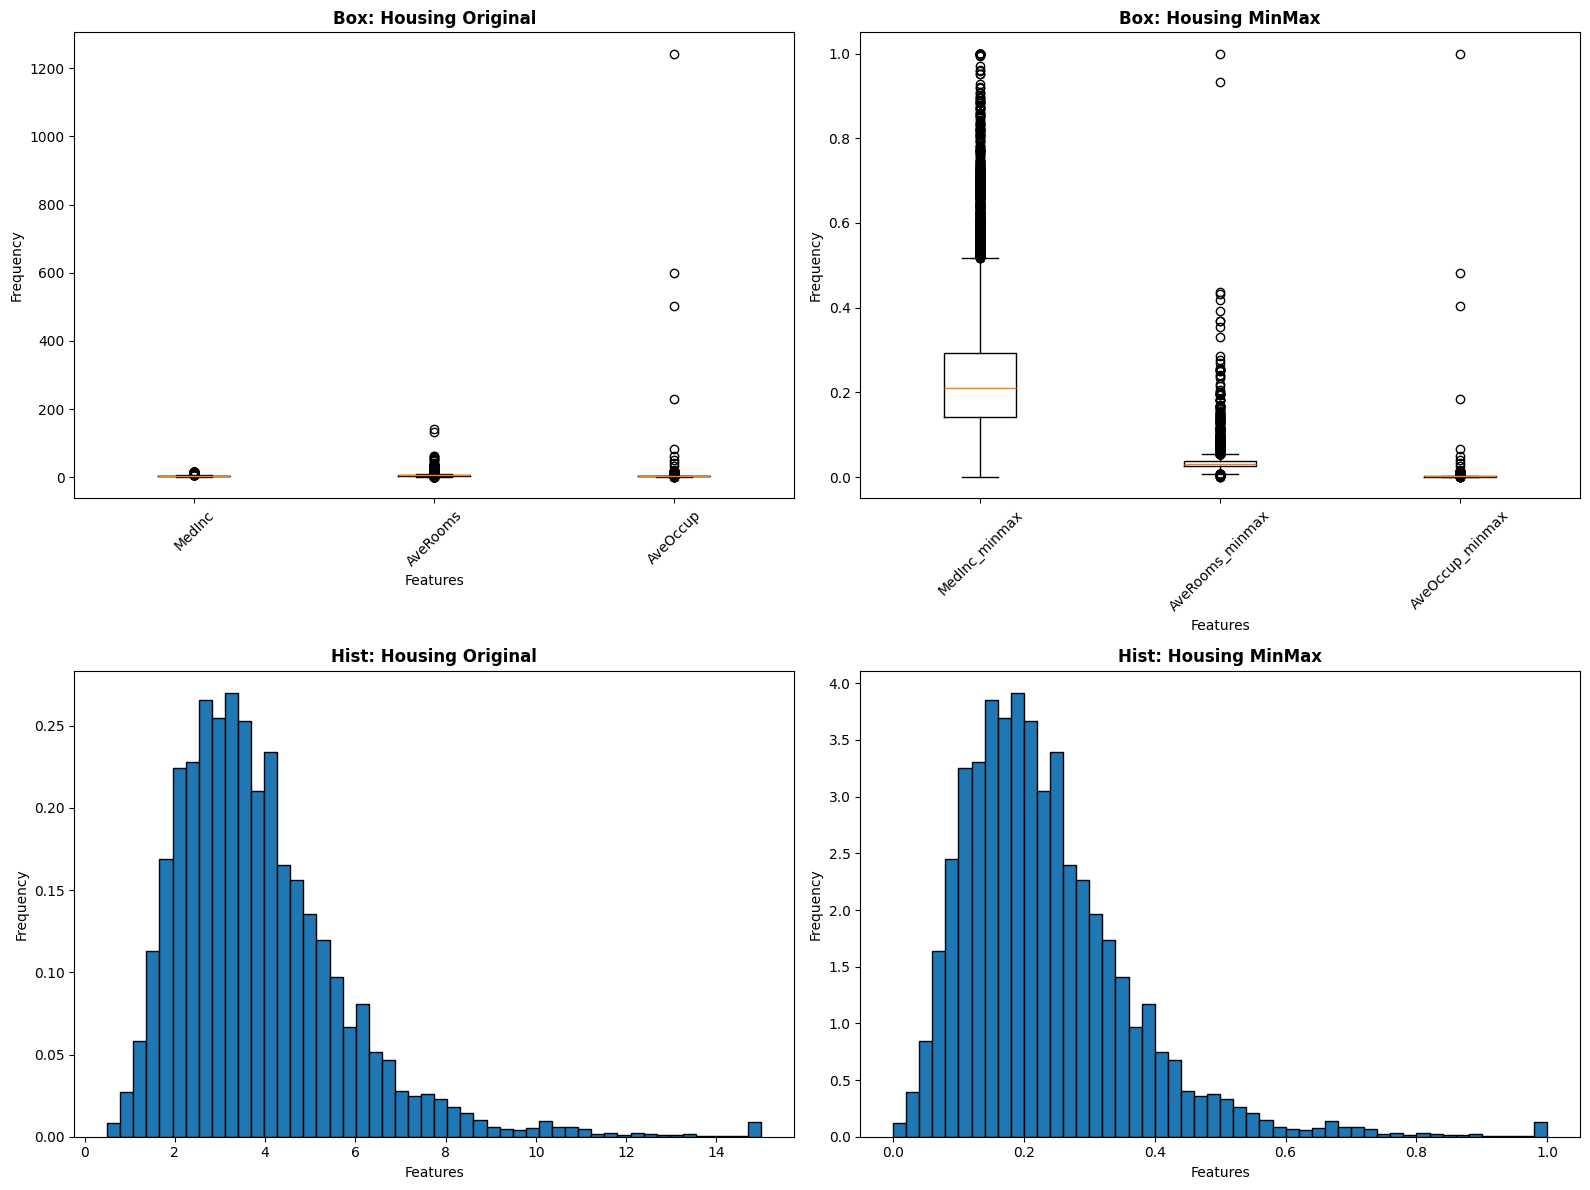

In [ ]:
#Min-Max transformation of housing_df
features = ['MedInc', 'AveRooms', 'AveOccup']
before_housing_minmax = housing_df[features]

scaler = MinMaxScaler()
#transform 
housing_minmax = pd.DataFrame(
    scaler.fit_transform(housing_df[features]),
    columns=[f'{col}_minmax' for col in features],
    index=housing_df.index
)
print(housing_minmax)

fig, axes = plt.subplots(2, 2, figsize=(16,12))

axes[0, 0].set_title('Box: Housing Original', fontweight='bold')
axes[0, 0].boxplot(before_housing_minmax)
axes[0, 0].set_xticklabels(before_housing_minmax.columns, rotation=45)
axes[0, 0].set_xlabel('Features')
axes[0, 0].set_ylabel('Frequency')


axes[0, 1].set_title('Box: Housing MinMax', fontweight='bold')
axes[0, 1].boxplot(housing_minmax)
axes[0, 1].set_xticklabels(housing_minmax.columns, rotation=45)
axes[0, 1].set_xlabel('Features')
axes[0, 1].set_ylabel('Frequency')


axes[1, 0].set_title('Hist: Housing Original', fontweight='bold')
axes[1, 0].hist(before_housing_minmax['MedInc'], bins=50, edgecolor='black', density=True)
# axes[1, 0].set_xticks(
#     ticks=range(1, len(before_housing_minmax.columns) + 1),
#     labels=before_housing_minmax.columns,
#     rotation=45
# )
axes[1, 0].set_xlabel('Features')
axes[1, 0].set_ylabel('Frequency')


axes[1, 1].set_title('Hist: {feature} MinMax', fontweight='bold')
axes[1, 1].hist(housing_minmax['MedInc_minmax'], bins=50, edgecolor='black', density=True)
# axes[1, 1].set_xticks(
#     ticks=range(1, len(housing_minmax.columns) + 1),
#     labels=housing_minmax.columns,
#     rotation=45
# )
axes[1, 1].set_xlabel('Features')
axes[1, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


## (Optional) Additional feature engineering

Add more techniques if you'd like to experiment further.

In [6]:
# YOUR CODE HERE (optional)


## Model evaluation

Now we'll compare model performance on the original dataset versus your engineered dataset.

### Evaluate datasets

In [7]:
# Save a copy of the engineered dataframe
housing_df.to_csv('housing_df.csv', index=False)

In [8]:
# Create linear regression model
model = LinearRegression()

# Evaluate on original dataset
scores_original = cross_val_score(
    model,
    original_housing_df.drop('MedHouseVal', axis=1),
    original_housing_df['MedHouseVal'],
    cv=10,
    scoring='r2'
)

# Evaluate on engineered dataset
scores_engineered = cross_val_score(
    model,
    housing_df.drop('MedHouseVal', axis=1),
    housing_df['MedHouseVal'],
    cv=10,
    scoring='r2'
)

engineered_mean = scores_engineered.mean()
original_mean = scores_original.mean()
mean_improvement = (engineered_mean - original_mean) / original_mean

print(f'\nMean improvement: {mean_improvement:.2f}%')


Mean improvement: 0.00%


### Visualize model performance comparison

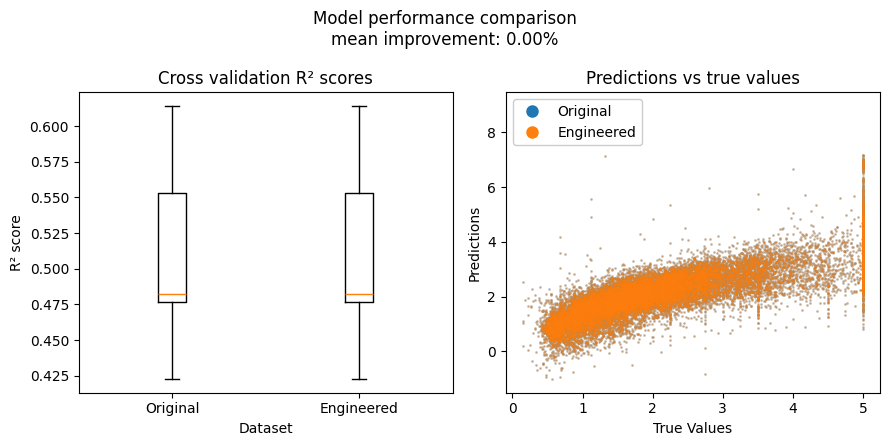

In [9]:
original_model = LinearRegression()
original_model.fit(original_housing_df.drop('MedHouseVal', axis=1), original_housing_df['MedHouseVal'])
original_predictions = original_model.predict(original_housing_df.drop('MedHouseVal', axis=1))

model = LinearRegression()
model.fit(housing_df.drop('MedHouseVal', axis=1), housing_df['MedHouseVal'])
predictions = model.predict(housing_df.drop('MedHouseVal', axis=1))

# Create boxplot comparing performance
data_to_plot = [scores_original, scores_engineered]
labels = ['Original', 'Engineered']

fig, axs = plt.subplots(1, 2, figsize=(9,4.5))

fig.suptitle(f'Model performance comparison\nmean improvement: {mean_improvement:.2f}%')

axs[0].set_title('Cross validation R² scores')
axs[0].boxplot(data_to_plot, tick_labels=labels)
axs[0].set_xlabel('Dataset')
axs[0].set_ylabel('R² score')

axs[1].set_title('Predictions vs true values')
axs[1].plot(
    original_housing_df['MedHouseVal'], original_predictions,
    'o', markersize=1, label='Original', alpha=0.25
)

axs[1].plot(
    housing_df['MedHouseVal'], predictions,
    'o', markersize=1, label='Engineered', alpha=0.25
)

axs[1].set_xlabel('True Values')
axs[1].set_ylabel('Predictions')

leg = axs[1].legend(loc='upper left', markerscale=8, framealpha=1)

for lh in leg.legend_handles: 
    lh.set_alpha(1)

plt.tight_layout()
plt.show()

## 3. Reflection

**Questions to consider**:

1. Which feature engineering techniques had the biggest impact on model performance?
2. Did adding more features always improve performance, or did some hurt it?
3. How might you further improve the engineered dataset?
4. What trade-offs did you consider (e.g., interpretability vs performance, complexity vs gains)?

**Your reflection**:

*Write your thoughts here...*